In [1]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 1#256 if torch.cuda.is_available() else 48
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = 16 # Set to your device

import json

torch.set_float32_matmul_precision('medium')

cuda:0


In [2]:
data_transforms_none = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # transforms.Resize([200,200])
])
train_ds = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=data_transforms_none)

def norm_stats(ds):
    L=len(ds)
    mean_total = np.zeros(3)
    std_total = np.zeros(3)
    for i in range(L):
        img = (ds.__getitem__(i))[0].numpy()
        img = img.reshape(img.shape[0],img.shape[1]*img.shape[2])

        mean_total += np.mean(img,axis=1)
        std_total += np.std(img,axis=1)

    means = (mean_total/L).tolist()
    stds = (std_total/L).tolist()

    return means, stds    

In [2]:
# means, stds = norm_stats(train_ds)

#Output from above line
means = [0.6598784563532518, 0.5282382175840284, 0.26685126321971003]
stds = [0.13364640444095852, 0.1672512971251833, 0.30953234263722934]


print(means)
print(stds)

[0.6598784563532518, 0.5282382175840284, 0.26685126321971003]
[0.13364640444095852, 0.1672512971251833, 0.30953234263722934]


In [3]:
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # transforms.Resize([200,200]),
    transforms.Normalize(means, stds)
])

In [4]:
test_set = torchvision.datasets.ImageFolder("./data/imgs/test/",transform=data_transforms)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)#, persistent_workers=True)

In [5]:
train_set = torchvision.datasets.ImageFolder("./data/imgs/train/",transform=data_transforms)
test_set = torchvision.datasets.ImageFolder("./data/imgs/test/",transform=data_transforms)
val_set = torchvision.datasets.ImageFolder("./data/imgs/val/",transform=data_transforms)

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)#, persistent_workers=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)#, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)#, persistent_workers=True)

In [6]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out,stride=1):
        super(ConvBlock, self).__init__()     # Call constructor
        middle_channel = (channels_in+channels_out)//2
        print(middle_channel)
        self.conv1 = nn.Conv2d(in_channels=channels_in,out_channels=middle_channel, kernel_size=3,stride=stride)
        self.conv2 = nn.Conv2d(in_channels=middle_channel,out_channels=channels_out, kernel_size=3,stride=stride)
        self.activ = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2)
        #self.batchnorm1 = nn.BatchNorm2d(middle_channel)
        #self.batchnorm2 = nn.BatchNorm2d(channels_out)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool(x)
        x = self.activ(x)

        x = self.conv2(x)
        x = self.activ(x)
        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=6, learning_rate=1e-3):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(3, 8,stride = 2)
        self.conv_blk2 = ConvBlock(8,16,stride = 2)
        
        # You can use other layers too, feel free to define them here
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=20)
        self.dropout = nn.Dropout(0.1)
        
        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(16*20*20,100)
        self.fc2 = nn.Linear(100,64)
        self.fc3 = nn.Linear(64, num_classes)

        self.leaky_relu = nn.LeakyReLU()
        
        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.conv_blk1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv_blk2(x)
        x = self.gap(x)

        x = torch.flatten(x,start_dim=1)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))

        return x
    
    def training_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        acc = self.train_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "train_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        acc = self.val_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "val_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)
        acc = self.test_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "test_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return preds, logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        return preds, logits, x, y

        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return valid_loader
    def test_dataloader(self):
        return test_loader

In [11]:
# Initialize the CNN model
max_epochs = 50 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/v2_2/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=200, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')

trainer_task = pl.Trainer(
    accelerator="auto",#"cpu",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback,early_stopping],
    logger=CSVLogger(save_dir="logs_task/v2_2/"),
    precision=32
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


5
12


In [10]:
# trainer_task.fit(model_cnn)

In [12]:
# torch.save(model_cnn,"./models/v2_2/model_1.pt")
model_cnn = torch.load("./models/v2_2/model_1.pt")
# model_cnn = Simple_CNN.load_from_checkpoint("./checkpoints_section/v2_2/epoch=7-step=315224.ckpt")

In [13]:
model_cnn.eval()
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         test_acc          │    0.8125688433647156     │
│         test_loss         │    0.5790451169013977     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5790451169013977,
  'test_acc': 0.8125688433647156,
  'epoch': 0.0}]

18


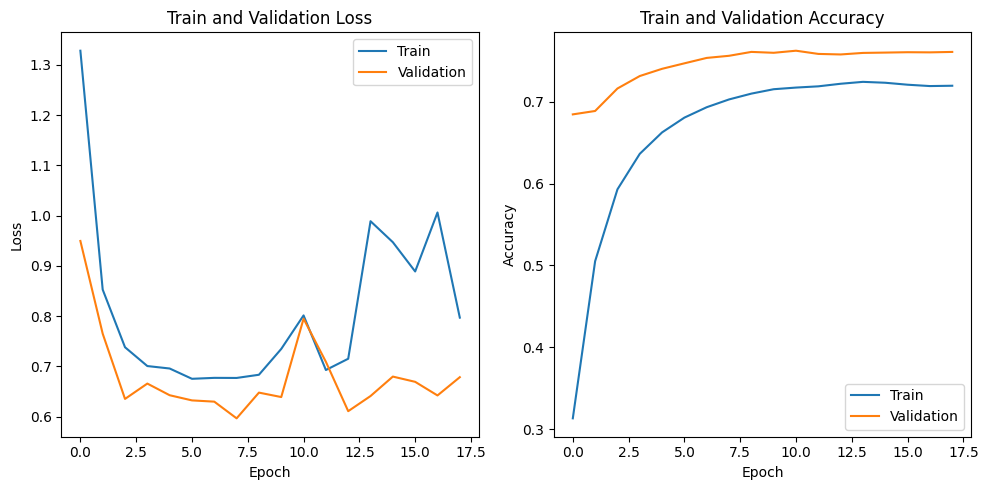

In [16]:
METRICS_PATH = "./logs_task/v2_2/lightning_logs/version_1"
metrics_task = pd.read_csv(METRICS_PATH + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.rcParams["figure.figsize"] = (10, 5)

plt.subplot(1,2,1)
epochs = len(metrics_task)-1
print(epochs)
plt.plot(metrics_task["train_loss"][0:epochs-1])
plt.plot(metrics_task["val_loss"][0:epochs-1])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(["Train", "Validation"]);

plt.subplot(1,2,2)

plt.plot(metrics_task["train_acc"][0:epochs-1])
plt.plot(metrics_task["val_acc"][0:epochs-1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(["Train", "Validation"]);

plt.tight_layout();

In [10]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Output()

: 

In [ ]:
# test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
# test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
# test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
# test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)
test_arr = [[],[],[],[]]
test_idx_list = [0,1,2,3]

for prediction in predictions:
    for test_idx in test_idx_list:
        item = prediction[test_idx]
        test_arr[test_idx].append(item.squeeze())

test_preds, test_outputs, test_inputs, test_labels = test_arr

print(test_outputs[0])

tensor([ -30.1500,  -34.1388,  -34.8046,  -32.3208,  -34.2876, -212.9769])


0.7550246492226015


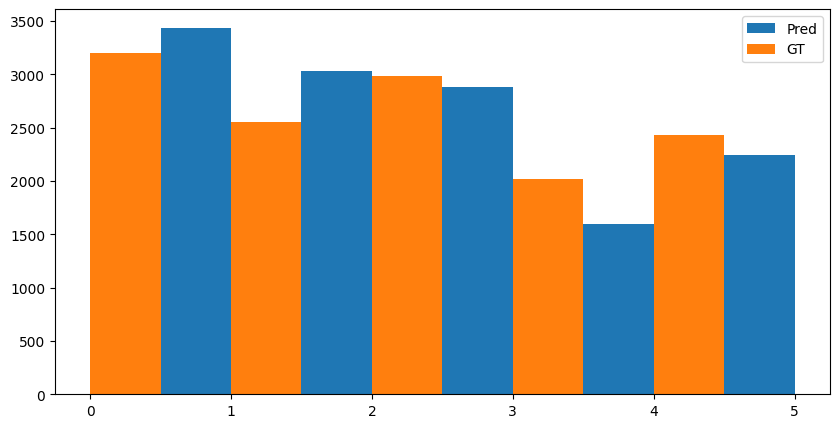

In [ ]:
print(np.sum(np.where(np.array(test_preds)==np.array(test_labels),1,0))/len(test_preds))
plt.hist(np.array(test_preds)+0.5,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="Pred");
plt.hist(np.array(test_labels),bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="GT");
plt.legend()
plt.show()


In [27]:
#GradCAM
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

In [ ]:

def saliency(index,plot=False, save_plot=False):
    # Retrieve the input image, true label, model output, predicted label for the selected index
    pred = test_preds[index]
    label = test_labels[index]
    output = test_outputs[index]
    image_original = test_inputs[index]
    # print(type(image_original))
    # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
    image = image_original.unsqueeze(0).clone()
    image.requires_grad = True

    # Compute the scores and gradients for the input image
    # To compute the scores, do a forward pass of the image and then take the argmax
    # Use this index to extract the score_max value from "scores"
    # Then perform a backward step so that it backpropagates the gradient
    scores = model_cnn.forward(image)
    score_max_index = torch.argmax(scores)
    score_max = scores[0, score_max_index]
    score_max.backward() # Do the backward step here for the gradient calculation

    # Calculate the saliency map by finding the maximum absolute gradient values across channels
    # You can use .abs() and torch.max()
    grad = image.grad
    grad_abs = torch.squeeze(grad.abs())
    grad_max = torch.max(grad_abs,dim=0).values
    #Unnormalise Image for display
    clean_img = []
    for ch in range(3):
        ch_layer = image_original[ch]
        corrected_layer = ch_layer*stds[ch]+means[ch]
        clean_img.append(corrected_layer.abs())
    clean_img = torch.tensor(np.array(clean_img)).permute(1,2,0)
    clean_img = np.array(clean_img)

    model = model_cnn
    model.eval()

    targets = [ClassifierOutputTarget(label.item())] #0-5
    target_layers = [model.conv_blk2.conv2]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=image, targets=targets)
        cam_image = show_cam_on_image(clean_img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])


    # # Create a subplot to display the original image and saliency map side by side
    if plot or save_plot:
        # images = np.hstack((cam , cam_image))
        # grad_cam = Image.fromarray(images)
        actions_list = ["INT","Right","Left","Down","Up",]
        plt.close()
        plt.figure()

        # Create a subplot to display the original image and saliency map side by side
        plt.rcParams["figure.figsize"] = (10, 9)
        plt.subplot(2,2,1)
        plt.imshow(grad_max)
        plt.title(f"Saliency (Max)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        #GradCAM Plot
        plt.subplot(2,2,4)
        plt.imshow(cam)
        plt.title(f"GradCAM\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        plt.subplot(2,2,3)
        plt.imshow(cam_image)
        plt.title(f"GradCAM Overlay\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.axis('off')

        #Original Image
        plt.subplot(2,2,2)
        plt.title(f"Original (Blue)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {index}")
        plt.imshow((clean_img))
        plt.axis('off')

        if plot:
            plt.show()
            print("Probabilities:",torch.nn.functional.softmax(output))

        if save_plot:
            plt.savefig(fname=f"./results/v2_2/{index}.png")
        
    return grad_max, cam, image_original

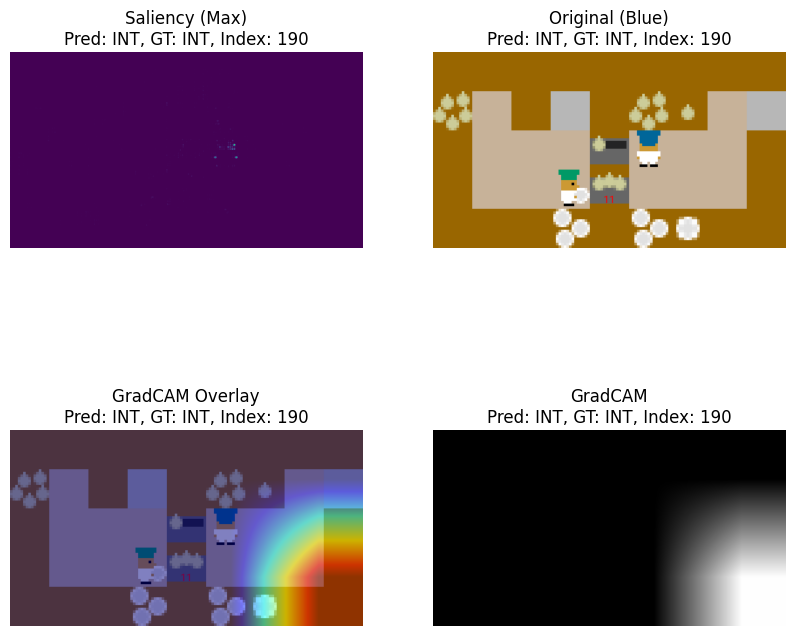

Probabilities: tensor([0.8647, 0.0146, 0.0244, 0.0667, 0.0296, 0.0000])


In [104]:
# grad_stats = []
# cam_stats = []
# input_stats = []
# for index in range(len(test_labels)):
#     grad_stat, cam_stat, _ = saliency(index, False, False)
#     grad_stats.append(np.array(grad_stat,dtype="float16"))
#     cam_stats.append(np.array(cam_stat,dtype="float16"))


# np.save("./results/v2_2/stats.npy",np.array(grad_stats))
# np.save("./results/v2_2/stats_gradcam.npy",np.array(cam_stats))

saliency(190, True, False);

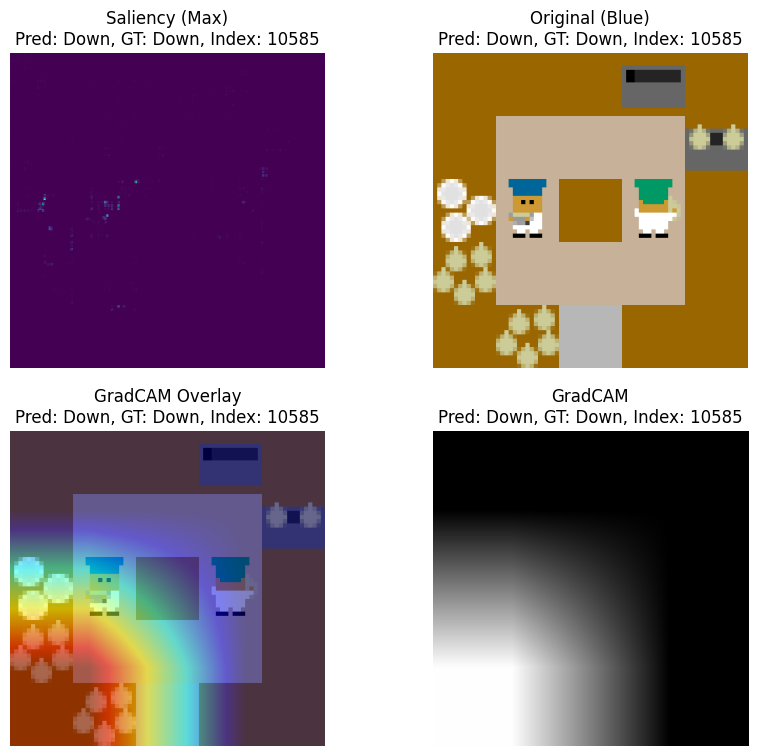

In [105]:
np.random.seed(1234)
results_indices = np.random.randint(0,len(test_labels),size=100)

for index in results_indices:
    _ = saliency(index, False, True)


In [270]:
def filenames(self, indices=[], basename=False):
        if indices: 
            # grab specific indices
            if basename:
                return [os.path.basename(self.imgs[i][0]) for i in indices]
            else:
                return [self.imgs[i][0] for i in indices]
        else:
            if basename:
                return [os.path.basename(x[0]) for x in self.imgs]
            else:
                return [x[0] for x in self.imgs]
            
torchvision.datasets.ImageFolder.filenames = filenames      


def saliencylowmem(testset,test_dfs,plot=False,save_plot=False, force_index = None, track_stats=False, track_stats2=False):
    #Keep memory usage low by get each prediction individually and perform stats at runtime
    # Square Stats
    # 0 - Bench (X) 0/1
    # 1 - Pot 0/1
    # 2 - Onion Source 0/1
    # 3 - Dish Source 0/1
    # 4 - Serving 0/1
    # 5 - Player 1
    # 6 - Player 2
    # 7 - None/Empty space

    square_stats = None
    square_stats2 = []
    if track_stats != False:
        square_stats = np.zeros([track_stats,8])

    for idx in range(len(test_set)):
        if force_index is not None: #Allows a specified index for analysis/debugging
            idx = force_index
        item = test_set.__getitem__(idx)

        # Retrieve the input image, true label
        image_original = item[0]
        label = item[1]
        global_index = testset.filenames([idx])[0].split("\\")[1].split(".")[0]

        # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
        image = image_original.unsqueeze(0).clone()
        image.requires_grad = True

        # Compute the scores and gradients for the input image
        # To compute the scores, do a forward pass of the image and then take the argmax
        # Use this index to extract the score_max value from "scores"
        # Then perform a backward step so that it backpropagates the gradient
        scores = model_cnn.forward(image)
        score_max_index = torch.argmax(scores)

        pred = score_max_index

        score_max = scores[0, score_max_index]
        score_max.backward() # Do the backward step here for the gradient calculation

        # Calculate the saliency map by finding the maximum absolute gradient values across channels
        # You can use .abs() and torch.max()
        grad = image.grad
        grad_abs = torch.squeeze(grad.abs())
        grad_max = torch.max(grad_abs,dim=0).values

        #Get state from pandas files
        #Ensure corrected ids test set is used
        row = test_dfs.iloc[int(global_index)]
        map_layout = row['layout']
        map_layout = map_layout.replace("\'","\"").replace("1"," ").replace("2"," ")
        map_layout = json.loads(map_layout)

        map_shape = (len(map_layout),len(map_layout[0]))
        grad_abs_sml = transforms.functional.resize(grad_abs, map_shape, interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True)
        grad_max_sml = torch.max(grad_abs_sml,dim=0).values


        #Unnormalise Image for display
        clean_img = []
        for ch in range(3):
            ch_layer = image_original[ch]
            corrected_layer = ch_layer*stds[ch]+means[ch]
            clean_img.append(corrected_layer.abs())
        clean_img = torch.tensor(np.array(clean_img)).permute(1,2,0)
        clean_img = np.array(clean_img)




        #Downscaling and then upscaling gradient image for smooth interpretation
        scale_factor = 3
        grad_abs_med = transforms.functional.resize(grad_abs, (map_shape[0]*scale_factor, map_shape[1]*scale_factor), interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True)
        grad_max_med = torch.max(grad_abs_med,dim=0).values
        up_down_grad_max = transforms.functional.resize(grad_max_med.unsqueeze(0), (grad_max.shape[0],grad_max.shape[1]), interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias= True).squeeze().abs()
        up_down_max = torch.max(up_down_grad_max)
        up_down_grad_max = (up_down_grad_max/(up_down_max.item()))
        grad_max_image = show_cam_on_image(clean_img, up_down_grad_max, use_rgb=True)

        # GradCAM results (Does not look right for CNN2 (very large patches of saliency without detail))
        # model = model_cnn
        # model.eval()
        # targets = [ClassifierOutputTarget(label)] #0-5
        # target_layers = [model.conv_blk2.conv2]
        # with GradCAM(model=model, target_layers=target_layers) as cam:
        #     grayscale_cams = cam(input_tensor=image, targets=targets)
        #     cam_image = show_cam_on_image(clean_img, grayscale_cams[0, :], use_rgb=True)
        # cam = np.uint8(255*grayscale_cams[0, :])
        # cam = cv2.merge([cam, cam, cam])

        #For top k salient tile(s) tracking stats
        if track_stats != False:
            track_topk = torch.topk(grad_max_sml.reshape(-1),track_stats)
            track_indices = track_topk.indices
            # print(track_topk)
            for track_idx in range(track_stats):
                max_idx = track_indices[track_idx]

                # max_pos = (((grad_max_sml==torch.max(grad_max_sml)).nonzero()).squeeze()) #singular max value (replaced with allowance for top k max values)
                max_pos = (max_idx//map_shape[1],max_idx%map_shape[1])
                # print(max_pos , (max_idx//map_shape[1],max_idx%map_shape[1]) , max_idx)
                max_item = map_layout[max_pos[0]][max_pos[1]]

                #Sort
                item_list = ['X','P','O','D','S']
                found = False
                for item_idx in range(len(item_list)):
                    target_item = item_list[item_idx]
                    if max_item==target_item:
                        square_stats[track_idx,item_idx]+=1
                        found = True
                        break
                if found == False:
                    state = json.loads(row['state'])
                    player_idx = row['player_idx']
                    p_idx = 5 #location for square stats counting

                    for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
                        #Position
                        player_pos = torch.tensor([player['position'][1],player['position'][0]]) #Corrected for rows then cols
                        # print(player_pos,max_pos)
                        if player_pos[0] == max_pos[0] and player_pos[1] == max_pos[1]:
                            square_stats[track_idx,p_idx]+=1
                            found=True
                            break
                        else:
                            p_idx+=1
                if found == False:
                    square_stats[track_idx,7]+=1

        #For individual ranking stats
        if track_stats2 != False:
            track_topk = torch.topk(grad_max_sml.reshape(-1),map_shape[0]*map_shape[1])
            track_indices = track_topk.indices

            stat2 = []
            for max_idx in track_indices:
                max_pos = (max_idx//map_shape[1],max_idx%map_shape[1])
                max_item = map_layout[max_pos[0]][max_pos[1]]

                if max_item == " ":
                    found = False
                    p_idx= 1
                    state = json.loads(row['state'])
                    player_idx = row['player_idx']

                    for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
                        #Position
                        player_pos = torch.tensor([player['position'][1],player['position'][0]]) #Corrected for rows then cols
                        # print(player_pos,max_pos)
                        if player_pos[0] == max_pos[0] and player_pos[1] == max_pos[1]:
                            found=True
                            break
                        else:
                            p_idx+=1
                    if found == True:
                        max_item = str(p_idx)
                    else:
                        max_item = "E"
                
                if max_item not in stat2:
                    stat2.append(max_item)
                
                if len(stat2)==8:
                    break
            square_stats2.append(stat2)
            

        # # Create a subplot to display the original image and saliency map side by side
        if plot or save_plot:
            # images = np.hstack((cam , cam_image))
            # grad_cam = Image.fromarray(images)
            actions_list = ["INT","Right","Left","Down","Up",]
            plt.close()
            plt.figure()

            # Create a subplot to display the original image and saliency map side by side
            plt.rcParams["figure.figsize"] = (10, 9)
            plt.subplot(2,2,1)
            plt.imshow(grad_max)
            plt.title(f"Saliency (Max)\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Downsampled saliency
            plt.subplot(2,2,4)
            plt.imshow(grad_max_sml)
            plt.title(f"Downsized Saliency\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Downsampled then upsampled overlay
            plt.subplot(2,2,3)
            plt.imshow(grad_max_image)
            plt.title(f"Smoothened Overlay\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.axis('off')

            #Original Image
            plt.subplot(2,2,2)
            plt.title(f"Original (Blue)\nPred: {actions_list[pred]}, GT: {actions_list[label]}, Index: {global_index}")
            plt.imshow((clean_img))
            plt.axis('off')

            plt.tight_layout()

            if plot:
                plt.show()
                print("Probabilities:",torch.nn.functional.softmax(scores))

            if save_plot:
                plt.savefig(fname=f"./results/v2_2/{index}.png")

        if force_index is not None:
            return square_stats, square_stats2

    return square_stats, square_stats2

In [271]:
test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()
force_idx = 0

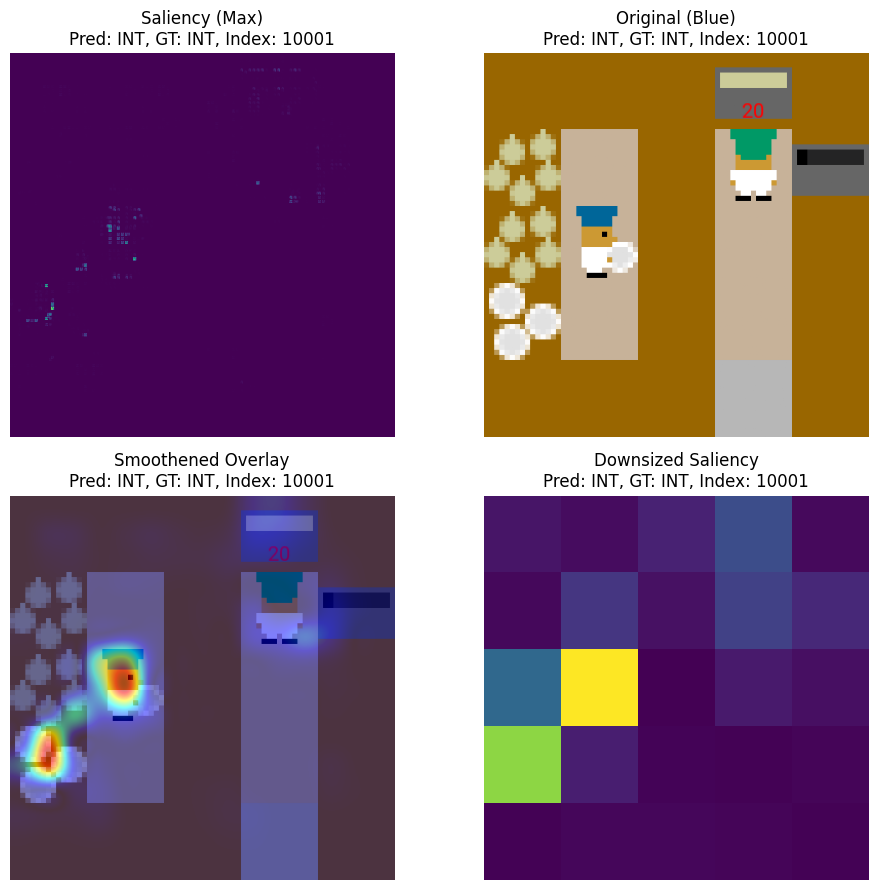

Probabilities: tensor([[8.3908e-01, 1.1998e-02, 4.7579e-02, 4.2290e-02, 5.9048e-02, 2.5689e-35]],
       grad_fn=<SoftmaxBackward0>)
(None, [['1', 'D', 'O', 'P', '2', 'E', 'X', 'S']])


In [273]:
print(saliencylowmem(test_set,test_dfs,plot=True,force_index=force_idx,track_stats2=True))
force_idx+=1

In [258]:
test_dfs = pd.read_pickle("./data/test_data.pickle").reset_index()
square_stats, _ = saliencylowmem(test_set,test_dfs,plot=False,save_plot=False,track_stats=5)
print(square_stats)

[[5.0000e+00 1.6000e+01 1.4000e+01 1.9200e+02 0.0000e+00 1.2948e+04
  4.8300e+02 0.0000e+00]
 [1.6960e+03 3.4260e+03 8.0300e+02 2.7680e+03 2.8000e+01 6.6100e+02
  3.7040e+03 5.7200e+02]
 [2.4660e+03 3.4350e+03 1.5730e+03 2.0610e+03 1.2800e+02 4.7000e+01
  2.3810e+03 1.5670e+03]
 [3.0670e+03 2.6650e+03 1.4570e+03 1.6050e+03 9.4000e+01 2.0000e+00
  2.0320e+03 2.7360e+03]
 [4.0130e+03 2.6150e+03 1.4090e+03 1.0160e+03 1.3300e+02 0.0000e+00
  1.3890e+03 3.0830e+03]]


In [ ]:
_, square_stats2 = saliencylowmem(test_set,test_dfs,plot=False,save_plot=False,track_stats2=True)
ss2_arr = np.array(square_stats2)
np.save("./results/v2_2/ranks.npy",ss2_arr)

[11055  8915  1318  7221 11468  7540   664  6137  6833  8471  9449  7322
  8222  1182  7916  8060  7962 10682 10360  7644 11589 11600  9161  2431
   246  2558  3503  5682  3824  5883  5196 12198  1530 13507 10983  7307
  6784  4841 12107 10576     3  1282  1299 11148  6603  4467  3691 11278
  3315 10695 12092  8682  6763  4014  7068  3153  9047  9997  4212 12896
 11148 12485   625  3039  8165 11935  8953 13308 11865  9300 10285  2576
 12329 12216  5206  8108   986 11219  2351  5138  9813  9902  2530 12069
  6950 12423  3044  1731  1774  2607  3062 10484 10614  8879  9103  2594
    10  3356  5124  2130]


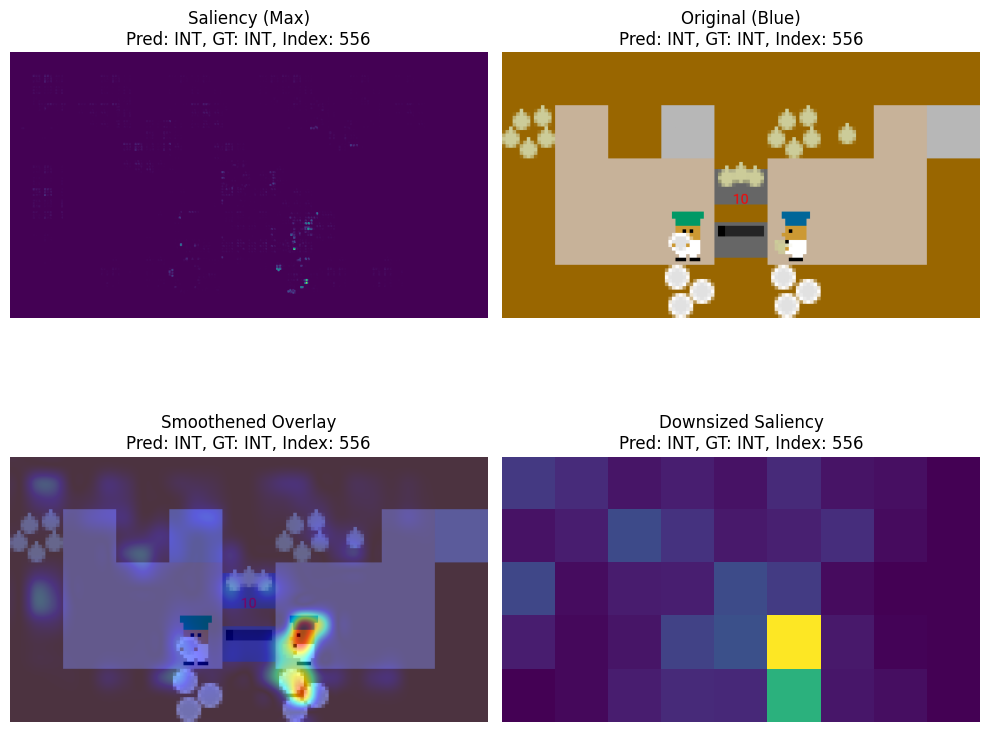

In [241]:
np.random.seed(1234)
results_indices = np.random.randint(0,len(test_dfs),size=100)
print(results_indices)

for index in results_indices:
    _ = saliencylowmem(test_set,test_dfs,plot=False,save_plot=True,force_index=index)